In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tempfile
from tensorflow.keras import layers

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
from contextlib import suppress
import os
import matplotlib.pyplot as plt

In [3]:
tf.keras.backend.clear_session()

In [8]:
BATCH_SIZE = 32
IMG_SIZE = 224


In [23]:
ds,ds_info = tfds.load('beans',as_supervised=True,with_info=True)

In [9]:
size = (IMG_SIZE, IMG_SIZE)

In [25]:
train_ds = ds['train'].map(lambda image, label: (tf.image.resize(image, size), label)).batch(BATCH_SIZE)
test_ds = ds['test'].map(lambda image, label: (tf.image.resize(image, size), label)).batch(BATCH_SIZE)

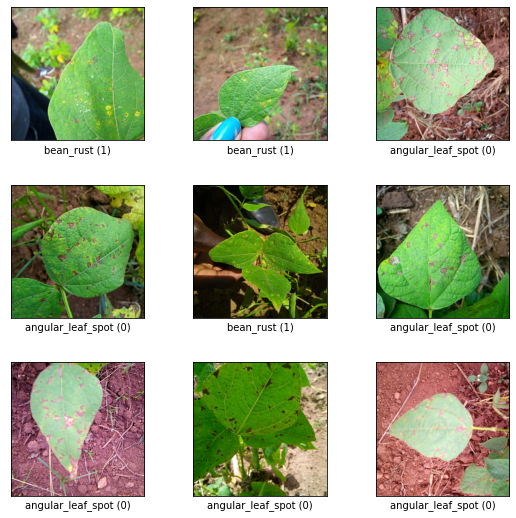

In [27]:
#train dataset examples
fig = tfds.show_examples(ds['train'], ds_info)

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2)
])

In [32]:
get_label_name = ds_info.features['label'].int2str

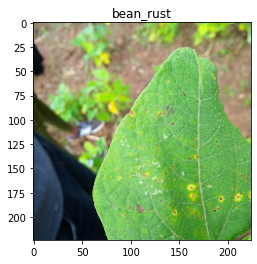

In [35]:
#retrive image for display purpouses
image, label = next(iter(train_ds))
_ = plt.imshow(image[0]/255)
_ = plt.title(get_label_name(label[0]))

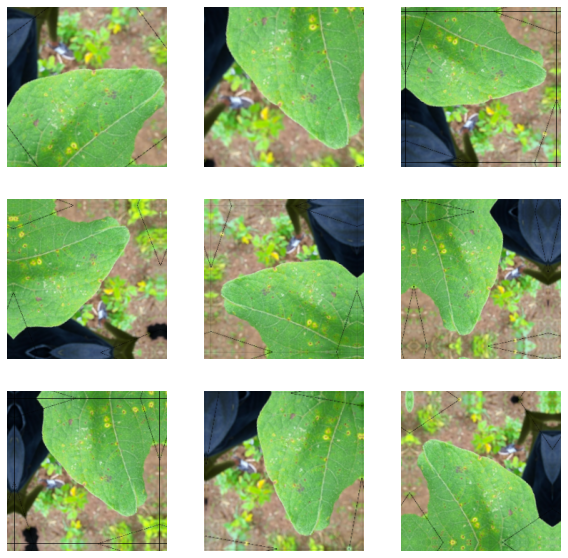

In [37]:
#display augmented images examples
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0]/255)
  plt.axis("off")

In [38]:
train_ds=train_ds.shuffle(BATCH_SIZE)

In [39]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [41]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9412608/9406464 [==============================] - 1s 0us/step


In [42]:
base_model.trainable = False


In [43]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [45]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with three units, number of clases in this example
outputs = tf.keras.layers.Dense(3)(x)
model = tf.keras.Model(inputs, outputs)

In [47]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [48]:
logdir = tempfile.mkdtemp()


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [50]:
%tensorboard --logdir={logdir} 

In [51]:
model.fit(train_ds, epochs=15,validation_data=test_ds,callbacks=[tensorboard_callback])

Epoch 1/15
33/33 [==============================] - 6s 176ms/step - loss: 1.3803 - accuracy: 0.3153 - val_loss: 1.0965 - val_accuracy: 0.4297
Epoch 2/15
33/33 [==============================] - 5s 147ms/step - loss: 1.2145 - accuracy: 0.3868 - val_loss: 0.9555 - val_accuracy: 0.5625
Epoch 3/15
33/33 [==============================] - 5s 152ms/step - loss: 1.0506 - accuracy: 0.4681 - val_loss: 0.8572 - val_accuracy: 0.6328
Epoch 4/15
33/33 [==============================] - 5s 148ms/step - loss: 0.9750 - accuracy: 0.5155 - val_loss: 0.7906 - val_accuracy: 0.6797
Epoch 5/15
33/33 [==============================] - 5s 162ms/step - loss: 0.8893 - accuracy: 0.5803 - val_loss: 0.7273 - val_accuracy: 0.6875
Epoch 6/15
33/33 [==============================] - 6s 169ms/step - loss: 0.8228 - accuracy: 0.6267 - val_loss: 0.6860 - val_accuracy: 0.7344
Epoch 7/15
33/33 [==============================] - 5s 158ms/step - loss: 0.7872 - accuracy: 0.6354 - val_loss: 0.6508 - val_accuracy: 0.7500
Epoch 

In [52]:
initial_epochs = 15

In [53]:
loss0, accuracy0 = model.evaluate(test_ds)


4/4 [==============================] - 0s 99ms/step - loss: 0.5160 - accuracy: 0.8203


In [54]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.52
initial accuracy: 0.82


In [55]:
base_model.trainable = True


In [56]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  155


In [57]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [60]:
model.fit(train_ds, epochs=10,validation_data=test_ds,callbacks=[tensorboard_callback])

Epoch 1/10
 1/33 [..............................] - ETA: 1s - loss: 0.5215 - accuracy: 0.7812WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


33/33 [==============================] - 11s 337ms/step - loss: 0.5082 - accuracy: 0.7892 - val_loss: 0.3994 - val_accuracy: 0.8203
Epoch 2/10
33/33 [==============================] - 10s 304ms/step - loss: 0.4116 - accuracy: 0.8269 - val_loss: 0.3654 - val_accuracy: 0.8594
Epoch 3/10
33/33 [==============================] - 8s 229ms/step - loss: 0.3731 - accuracy: 0.8540 - val_loss: 0.2939 - val_accuracy: 0.9141
Epoch 4/10
33/33 [==============================] - 9s 285ms/step - loss: 0.3585 - accuracy: 0.8511 - val_loss: 0.2841 - val_accuracy: 0.8984
Epoch 5/10
33/33 [==============================] - 9s 286ms/step - loss: 0.3020 - accuracy: 0.8772 - val_loss: 0.2482 - val_accuracy: 0.9141
Epoch 6/10
33/33 [==============================] - 7s 227ms/step - loss: 0.2848 - accuracy: 0.8849 - val_loss: 0.2423 - val_accuracy: 0.9062
Epoch 7/10
33/33 [==============================] - 9s 281ms/step - loss: 0.2576 - accuracy: 0.9014 - val_loss: 0.2165 - val_accuracy: 0.9297
Epoch 8/10
33/3